# Clasificación

La clasificación es la tarea de predecir resultados/etiquetas categóricas.

Las variables categóricas pueden ser binarias, multinomiales u ordinales.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import os

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## MedMNIST

Usaremos el conjunto **MedMNIST**, una colección de 18 *datasets* estandarizados para la clasificación de imágenes biomédicas 2D y 3D.


In [2]:
# Fetch the MedMNIST dataset
import medmnist

# Choose a specific MedMNIST dataset (e.g., 'pathmnist')
data_flag = 'bloodmnist'
download = True

# Ensure the target folder exists
os.makedirs('./datasets/ch4', exist_ok=True)

# Load the chosen MedMNIST dataset
info = medmnist.INFO[data_flag]
dataset_class = getattr(medmnist, info['python_class'])
train_dataset = dataset_class(split='train', download=download, root='./datasets/ch4')
test_dataset = dataset_class(split='test', download=download, root='./datasets/ch4')

Using downloaded and verified file: ./datasets/ch4\bloodmnist.npz
Using downloaded and verified file: ./datasets/ch4\bloodmnist.npz


Antes de empezar a trabajar, echemos un vistazo al conjunto de datos.

In [3]:
train_dataset

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: ./datasets/ch4
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY

<Axes: ylabel='Count'>

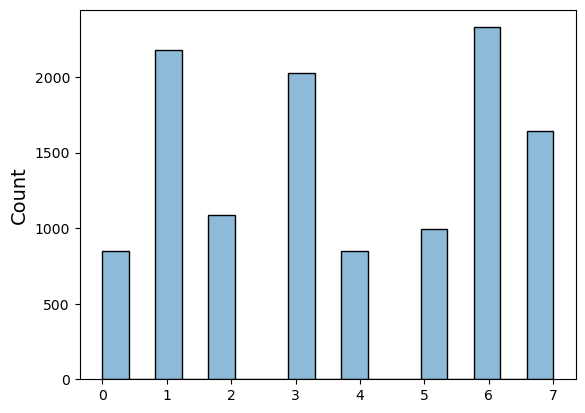

In [4]:
import seaborn as sns
sns.histplot(train_dataset.labels, legend=False)

In [5]:
X_train, y_train = train_dataset.imgs, train_dataset.labels 

In [6]:
X_train.shape

(11959, 28, 28, 3)

In [7]:
y_train.shape

(11959, 1)

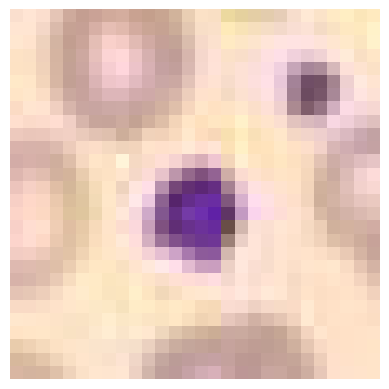

In [8]:
some_img = X_train[0,...]

plt.imshow(some_img)
plt.axis("off")
plt.show()

In [9]:
y_train[1]

array([3], dtype=uint8)

Veámoslo con más detalle:

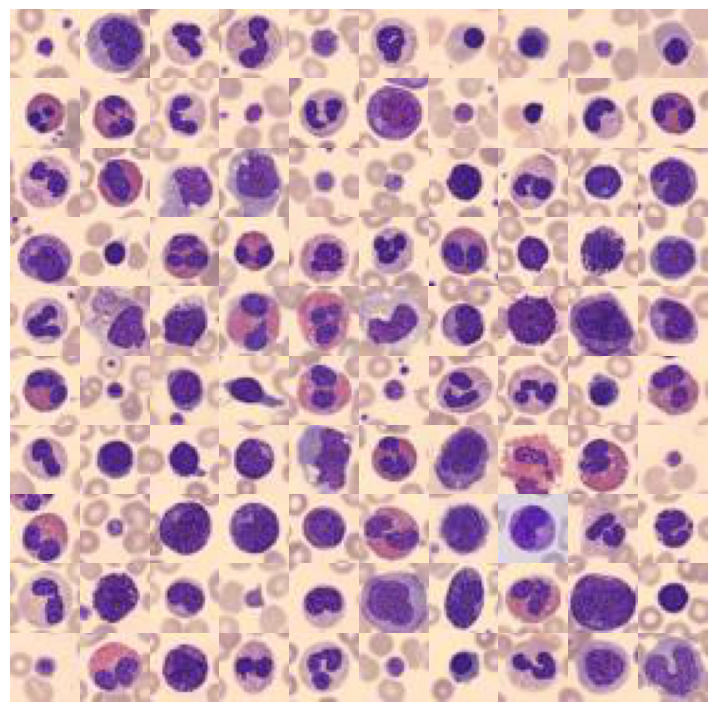

In [10]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X_train[:100]):
    plt.subplot(10, 10, idx + 1)
    plt.imshow(image_data)
    plt.axis("off")
    
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

### Conjunto de entrenamiento y prueba

Siempre debemos crear un **conjunto de prueba** que permanezca al margen hasta la evaluación final. A menudo se divide además en **entrenamiento**, **validación** y **prueba**. Barajar (*shuffle*) las filas evita ordenaciones indeseadas.


Preparemos los datos de prueba:

In [11]:
X_test, y_test = test_dataset.imgs, test_dataset.labels

## Entrenamiento de un clasificador binario

Como ejemplo, entrenaremos un clasificador para distinguir entre **dos clases** (p. ej., neutrófilo vs. no‑neutrófilo).


In [12]:
# Let’s create the target vectors for this classification task
y_train_binary = (y_train == 6)  
y_test_binary = (y_test == 6)

In [13]:
y_train_binary
# Check the unique classes and their counts
print(np.unique(y_train_binary, return_counts=True))

(array([False,  True]), array([9629, 2330], dtype=int64))


In [14]:
# To work with SGD we have to reshape the data to 2D: (n_samples, n_features)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [15]:
# Let's update the example image
some_img = X_train[1,...].flatten()

In [16]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train_binary.shape}")

X_train shape: (11959, 2352)
y_train shape: (11959, 1)


In [17]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=2000)
sgd_clf.fit(X_train, y_train_binary)

SGDClassifier(max_iter=2000, random_state=42)

In [18]:
sgd_clf.predict([some_img.flatten()])

array([False])

### Descenso del Gradiente

El **Descenso del Gradiente (GD)** es un algoritmo de optimización que actualiza los parámetros en la dirección del **gradiente negativo** de la función de coste hasta converger a un mínimo.


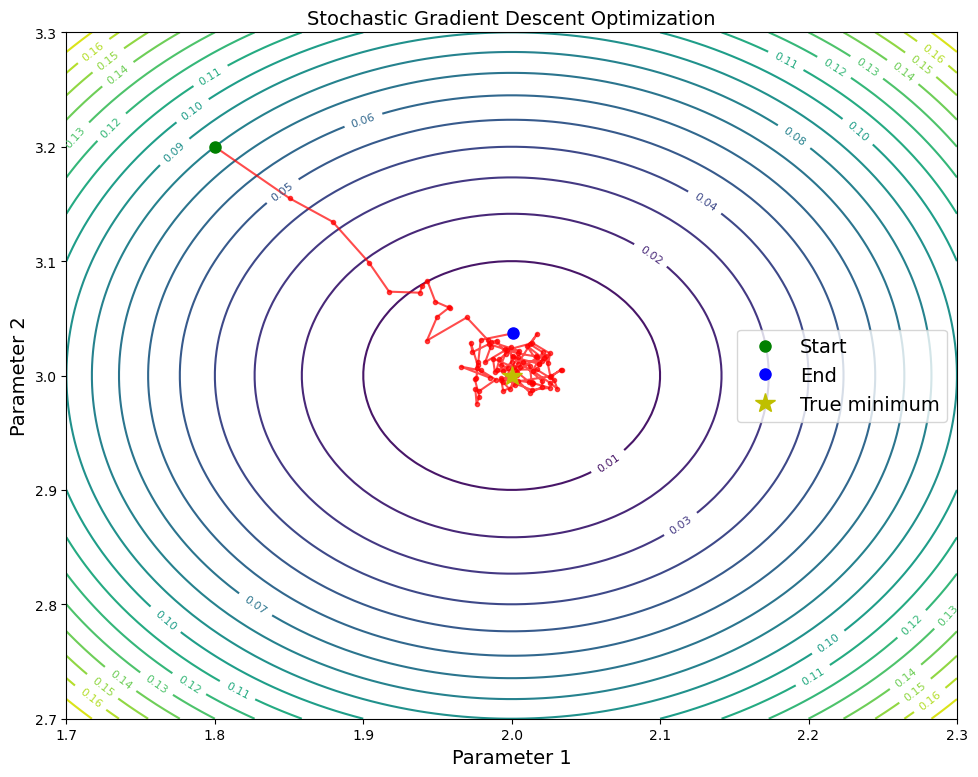

Final position: (2.0008, 3.0369)
Distance from true minimum: 0.0369


In [19]:
def cost_function(x, y):
    return (x - 2)**2 + (y - 3)**2

def gradient(x, y):
    return np.array([2*(x - 2), 2*(y - 3)])

def sgd(learning_rate, n_iterations, initial_x, initial_y):
    x, y = initial_x, initial_y
    path = [(x, y)]
    
    for _ in range(n_iterations):
        grad = gradient(x, y)
        noise = np.random.normal(0, 0.1, 2)  # Reduced noise for clearer visualization
        x -= learning_rate * (grad[0] + noise[0])
        y -= learning_rate * (grad[1] + noise[1])
        path.append((x, y))
    
    return np.array(path)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create a grid of points (zoomed in)
x = np.linspace(1.7, 2.3, 100)
y = np.linspace(2.7, 3.3, 100)
X, Y = np.meshgrid(x, y)

# Calculate Z values for contour plot
Z = cost_function(X, Y)

# Plot contours
contours = ax.contour(X, Y, Z, levels=20, cmap='viridis')
ax.clabel(contours, inline=True, fontsize=8)

# Run SGD
path = sgd(learning_rate=0.1, n_iterations=100, initial_x=1.8, initial_y=3.2)

# Plot the SGD path
ax.plot(path[:, 0], path[:, 1], 'ro-', linewidth=1.5, markersize=3, alpha=0.7)
ax.plot(path[0, 0], path[0, 1], 'go', markersize=8, label='Start')
ax.plot(path[-1, 0], path[-1, 1], 'bo', markersize=8, label='End')

# Plot the true minimum
ax.plot(2, 3, 'y*', markersize=15, label='True minimum')

ax.set_xlabel('Parameter 1')
ax.set_ylabel('Parameter 2')
ax.set_title('Stochastic Gradient Descent Optimization')
ax.legend()

# Set axis limits for zoomed-in view
ax.set_xlim(1.7, 2.3)
ax.set_ylim(2.7, 3.3)

plt.tight_layout()
plt.show()

# Print final position
print(f"Final position: ({path[-1, 0]:.4f}, {path[-1, 1]:.4f})")
print(f"Distance from true minimum: {np.linalg.norm(path[-1] - np.array([2, 3])):.4f}")

Para implementar GD, se necesita el **gradiente** de la pérdida con respecto a cada parámetro. En regresión MSE:

$$\nabla_\theta \mathrm{MSE}(\theta) = \frac{2}{m}\,\mathbf{X}^T(\mathbf{X}\theta - \mathbf{y}).$$


#### Actualización de los parámetros

El algoritmo inicializa aleatoriamente los parámetros ($\theta$) y luego los mejora gradualmente.
En cada paso intenta **disminuir la función de coste** (p. ej., el MSE), calcula el **gradiente** de la función de pérdida con respecto a $\theta$, y actualiza $\theta$ dando un **pequeño paso en la dirección del gradiente negativo** hasta que el algoritmo converge a un mínimo.


$$\theta^{(t+1)} = \theta^{(t)} - \eta\,\nabla_\theta MSE(\theta^{(t)})$$

donde el hiperparámetro $\eta$ se denomina **tasa de aprendizaje** (*learning rate*).


La **tasa de aprendizaje** controla el tamaño del paso. Si es demasiado grande, puede **divergir**; si es demasiado pequeña, necesitará muchas iteraciones para **converger**.


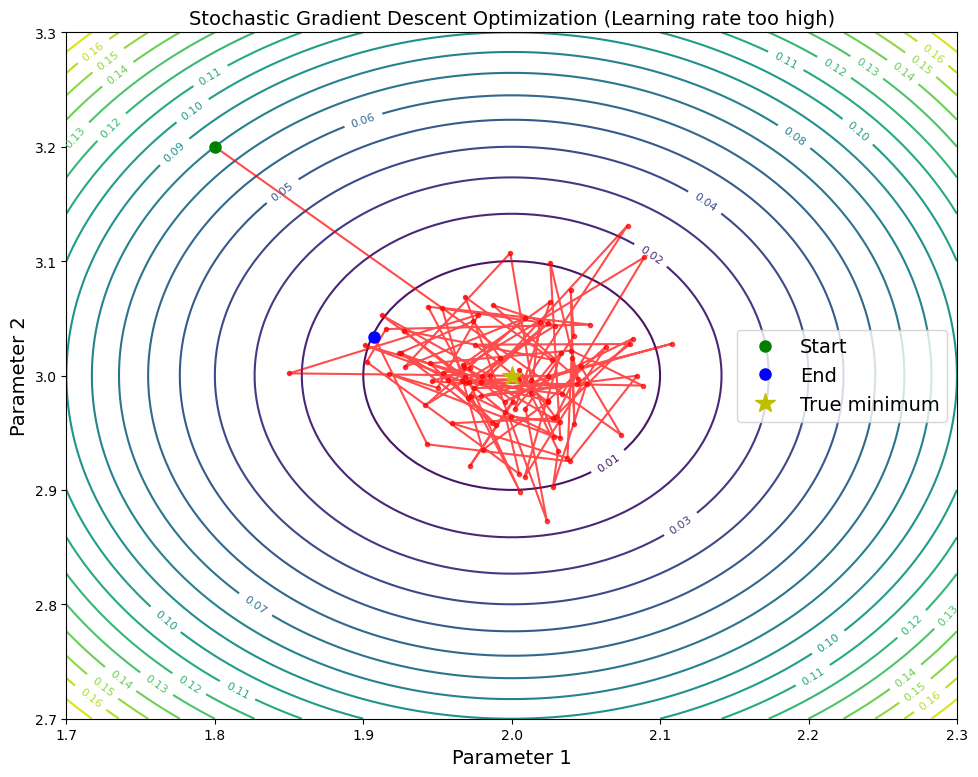

Final position: (1.9074, 3.0338)
Distance from true minimum: 0.0985


In [20]:
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create a grid of points (zoomed in)
x = np.linspace(1.7, 2.3, 100)
y = np.linspace(2.7, 3.3, 100)
X, Y = np.meshgrid(x, y)

# Calculate Z values for contour plot
Z = cost_function(X, Y)

# Plot contours
contours = ax.contour(X, Y, Z, levels=20, cmap='viridis')
ax.clabel(contours, inline=True, fontsize=8)

# Run SGD
path = sgd(learning_rate=0.5, n_iterations=100, initial_x=1.8, initial_y=3.2)

# Plot the SGD path
ax.plot(path[:, 0], path[:, 1], 'ro-', linewidth=1.5, markersize=3, alpha=0.7)
ax.plot(path[0, 0], path[0, 1], 'go', markersize=8, label='Start')
ax.plot(path[-1, 0], path[-1, 1], 'bo', markersize=8, label='End')

# Plot the true minimum
ax.plot(2, 3, 'y*', markersize=15, label='True minimum')

ax.set_xlabel('Parameter 1')
ax.set_ylabel('Parameter 2')
ax.set_title('Stochastic Gradient Descent Optimization (Learning rate too high)')
ax.legend()

# Set axis limits for zoomed-in view
ax.set_xlim(1.7, 2.3)
ax.set_ylim(2.7, 3.3)

plt.tight_layout()
plt.show()

# Print final position
print(f"Final position: ({path[-1, 0]:.4f}, {path[-1, 1]:.4f})")
print(f"Distance from true minimum: {np.linalg.norm(path[-1] - np.array([2, 3])):.4f}")

#### Ejemplo de regresión con GD


In [21]:
import numpy as np

np.random.seed(42)  # to make this code example reproducible
m = 100  # number of instances
X = 2 * np.random.rand(m, 1)  # column vector
y = 4 + 3 * X + np.random.randn(m, 1)  # column vector

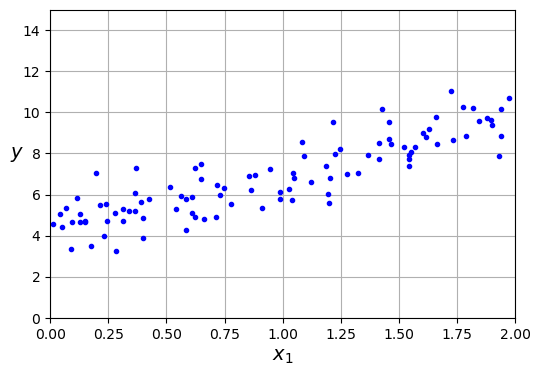

In [22]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

In [23]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # add x0 = 1 to each instance
# theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # add x0 = 1 to each instance


In [24]:
eta = 0.1  # learning rate
n_epochs = 1000
m = len(X_b)  # number of instances

np.random.seed(42)
theta = np.random.randn(2, 1)  # randomly initialized model parameters

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

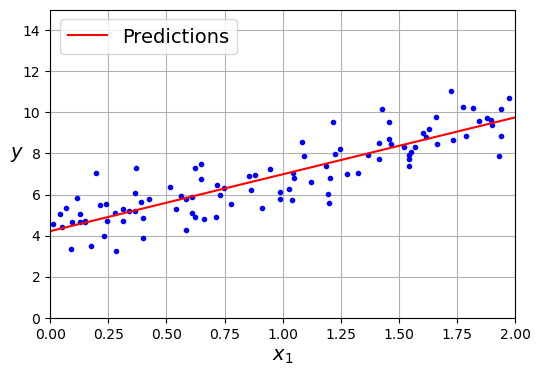

In [25]:
plt.figure(figsize=(6, 4)) 
plt.plot(X, y, "b.")
y_predict = X_new_b @ theta
plt.plot(X_new, y_predict, "r-", label="Predictions")


plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")
plt.show()

Parámetros del modelo entrenado:

In [26]:
theta

array([[4.21509616],
       [2.77011339]])

#### Descenso del Gradiente con distintas tasas de aprendizaje

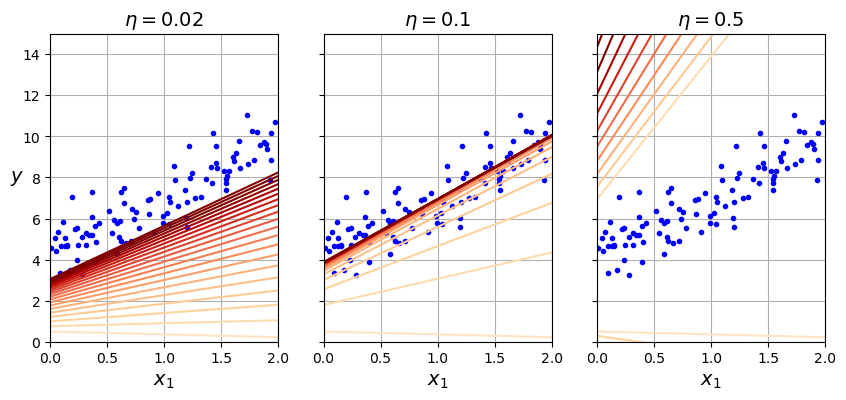

In [27]:
import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)

plt.show()

#### Descenso Estocástico del Gradiente (SGD)

El problema del GD por lotes es que recalcula el gradiente sobre **todo** el conjunto de entrenamiento en cada paso; con conjuntos grandes es **lento**. **SGD** aproxima el gradiente usando **una** instancia (o un *minibatch* pequeño), logrando actualizaciones **rápidas** y con **ruido** útil para escapar de mínimos locales.


Randomness is *good* to escape from local optima, but *bad* because it means
that the algorithm can never settle at the minimum. 

One solution is to gradually reduce the tasa de aprendizaje. The steps start out large (which helps make
quick progress and escape local minima), then get smaller and smaller, allowing the
algorithm to settle at the global minimum. 
The function that determines the tasa de aprendizaje at each iteration is called the **learning schedule**. 

If the tasa de aprendizaje is reduced too quickly, you may get stuck in a local minimum, or even end up frozen halfway to the minimum. If the tasa de aprendizaje is reduced too slowly, you may jump around the minimum for a
long time and end up with a suboptimal solution if you halt entrenamientoing too early.


In [28]:
theta_path_sgd = [] 

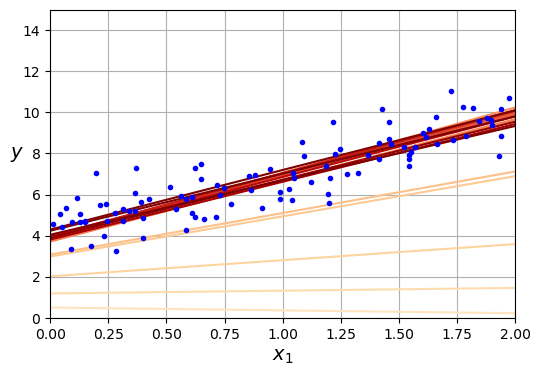

In [29]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

n_shown = 20  # just needed to generate the figure below
plt.figure(figsize=(6, 4))  # not needed, just formatting

for epoch in range(n_epochs):
    for iteration in range(m):

        # these 4 lines are used to generate the figure
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)  # for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)  # extra code to generate the figure

# extra code – this section beautifies and saves the figure
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()

plt.show()

Mientras que el código de Descenso del Gradiente por lotes recorrió 1.000 veces todo el conjunto de entrenamiento, este código pasa por el conjunto de entrenamiento solo 50 veces y alcanza una solución bastante buena.


In [30]:
theta

array([[4.21076011],
       [2.74856079]])

Ten en cuenta que, como las instancias se eligen aleatoriamente, algunas pueden seleccionarse varias veces por **época**, mientras que otras pueden no seleccionarse en absoluto.

> Al usar **Descenso Estocástico del Gradiente (SGD)**, las instancias de entrenamiento deben ser **independientes e idénticamente distribuidas (IID)** para garantizar que, en promedio, los parámetros se desplacen hacia el óptimo global. Una forma sencilla de asegurar esto es **barajar** (mezclar aleatoriamente) las instancias durante el entrenamiento.

Para realizar **Regresión Lineal** usando SGD con **Scikit-Learn**, puedes emplear la clase `SGDRegressor`, que por defecto optimiza la función de coste de **error cuadrático**.

El siguiente código se ejecuta como máximo durante **1000 épocas** (`max_iter=1000`) o hasta que la **pérdida** disminuya **menos de 1e-3** en una época (`tol=1e-3`), comenzando con una **tasa de aprendizaje** de **0.1** (`eta0=0.1`) y usando la **programación de tasa de aprendizaje** por defecto ($\eta \propto 1/t$).


In [31]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets


SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [32]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

## Medidas de rendimiento

Evaluar un clasificador suele ser considerablemente más complicado que evaluar un regresor.

### Medir la exactitud con validación cruzada

Usemos la función `cross_val_score()` para evaluar el modelo `SGDClassifier` mediante validación cruzada K-fold con 3 particiones.

La validación cruzada K-fold consiste en dividir el conjunto de entrenamiento en K particiones (en este caso, 3), y luego hacer predicciones y evaluarlas en cada partición usando un modelo entrenado con las particiones restantes.

> La validación cruzada permite obtener no solo una estimación del rendimiento del modelo,
> sino también una medida de la precisión de esa estimación (es decir, su desviación estándar).
> Pero tiene el costo de entrenar el modelo varias veces, por lo que no siempre es viable.


In [33]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_binary, cv=3, scoring="accuracy")

array([0.85502884, 0.84972403, 0.86402408])

La **exactitud** (proporción de predicciones correctas) es relativamente alta en todas las particiones de validación cruzada.

Sin embargo, comparemosla con el rendimiento de un **clasificador *dummy*** que siempre infiere la **etiqueta de clase más frecuente** en el vector `y` observado que se pasa a `fit`.


In [34]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_binary)
print(any(dummy_clf.predict(X_train)))

False


In [35]:
cross_val_score(dummy_clf, X_train, y_train_binary, cv=3, scoring="accuracy")

array([0.80511663, 0.80531862, 0.80506774])

Esto se debe a que solo alrededor del 20% de las imágenes son de la clase 6; por lo tanto, si siempre supones que una imagen **no** es un 6, acertarás aproximadamente el 80% de las veces.

> Esto demuestra por qué la **exactitud** no suele ser la métrica de rendimiento preferida para clasificadores, especialmente cuando se trabaja con **conjuntos de datos desbalanceados** (es decir, cuando algunas clases son mucho más frecuentes que otras).


<Axes: ylabel='Count'>

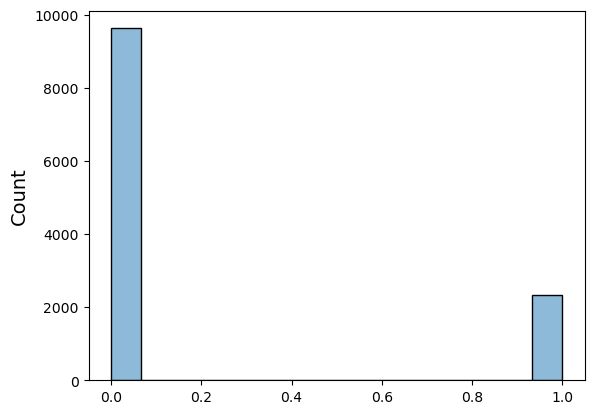

In [36]:
sns.histplot(y_train_binary, legend=False)

### Matriz de confusión

La idea general es contar cuántas veces las instancias de la clase A se clasifican como clase B.

Para calcular la **matriz de confusión**, primero necesitas un conjunto de predicciones para compararlas con los valores objetivo reales. 

Al igual que la función `cross_val_score()`, `cross_val_predict()` realiza validación cruzada K-fold, pero en lugar de devolver las puntuaciones de evaluación, devuelve las predicciones realizadas en cada pliegue de prueba. Esto significa que obtienes una predicción *limpia* para cada instancia del conjunto de entrenamiento (*limpia* en el sentido de que la predicción la hace un modelo que nunca vio esos datos durante el entrenamiento).


In [37]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_binary, cv=3)

Vamos a **obtener la matriz de confusión** usando la función `confusion_matrix()`.

Solo hay que pasarle las **clases objetivo** (`y_entrenamiento_binary`) y las **clases predichas** (`y_entrenamiento_pred`):


In [38]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_binary, y_train_pred)
cm

array([[9160,  469],
       [1250, 1080]], dtype=int64)

Cada fila de una **matriz de confusión** representa una clase real, mientras que cada columna representa una clase predicha.

> Un clasificador perfecto solo tendría verdaderos positivos y verdaderos negativos, de modo que su matriz de confusión tendría valores distintos de cero únicamente en su diagonal principal.


## Precision and Recall

La **matriz de confusión** aporta mucha información, pero a veces preferimos una métrica más concisa.

Una interesante es la proporción de aciertos entre las **predicciones positivas**; se denomina la **precisión** del clasificador:

$\mathrm{precisión} = \frac{TP}{TP + FP}$

donde $TP$ es el número de **verdaderos positivos** y $FP$ es el número de **falsos positivos**.


In [39]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_binary, y_train_pred) 

0.697224015493867

Una forma trivial de obtener **precisión** perfecta es hacer **una única predicción positiva** y asegurarse de que sea correcta (precisión = 1/1 = 100%). Esto no sería muy útil, ya que el clasificador ignoraría todas las demás instancias positivas. Por ello, la precisión suele usarse junto con otra métrica llamada **exhaustividad** (*recall*), también conocida como **sensibilidad** o **tasa de verdaderos positivos (TPR)**.

Esta es la proporción de instancias positivas que el clasificador detecta correctamente:

$$
\mathrm{recall} = \frac{TP}{TP + FN} 
$$


In [40]:
recall_score(y_train_binary, y_train_pred)  

0.463519313304721

Ahora el clasificador no parece tan bueno como cuando examinamos su **exactitud**.


### Puntuación $F_1$

A menudo conviene combinar **precisión** y **exhaustividad (recall)** en una única métrica llamada **F1**, especialmente si necesitas una forma sencilla de comparar dos clasificadores. La puntuación $F_1$ es la **media armónica** de precisión y *recall*:

$$
F_1 = \frac{2}{\frac{1}{\mathrm{precisión}} + \frac{1}{\mathrm{recall}}}
$$


In [42]:
from sklearn.metrics import f1_score

f1_score(y_train_binary, y_train_pred)

0.5568445475638051

La puntuación $F_1$ favorece a los clasificadores que tienen **precisión** y **exhaustividad (recall)** similares. Esto no siempre es lo deseado: en algunos contextos importa sobre todo la **precisión**, y en otros importa realmente el **recall**.

Por desgracia, no se puede tener ambas al máximo: al aumentar la **precisión** suele disminuir el **recall**, y viceversa. A esto se le llama el **compromiso precisión/recall** (*precision–recall trade-off*).


### Compromiso precisión/recall

Para entender este compromiso, veamos cómo el `SGDClassifier` toma sus decisiones de clasificación. Para cada instancia calcula una **puntuación** basada en una **función de decisión**, y si esa puntuación es mayor que un **umbral**, asigna la instancia a la clase positiva; en caso contrario, a la clase negativa.

`Scikit-Learn` no permite fijar el umbral directamente, pero sí proporciona acceso a las **puntuaciones de decisión** que utiliza para hacer las predicciones.


In [43]:
y_scores = sgd_clf.decision_function([some_img.flatten()])
y_scores

array([-16.64535558])

In [44]:
threshold = 0
y_some_image_pred = (y_scores > threshold)

El `SGDClassifier` utiliza un **umbral** igual a 0, por lo que el código anterior devuelve el mismo resultado que el método `predict()`.


In [45]:
y_some_image_pred

array([False])

Podemos ver que si aumentamos el **umbral**, la **exhaustividad (recall)** disminuye.


In [46]:
threshold = 10
y_some_image_pred = (y_scores > threshold)
y_some_image_pred

array([False])

How do we decide which umbral to use? 

First, let's get the puntuacións of all instances in the entrenamientoing set.

In [47]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Define StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=3)

# Placeholder to store predictions
y_scores = np.zeros(len(X_train))

# Manually run cross-validation
for train_index, test_index in stratified_kfold.split(X_train, y_train_binary):
    # Train model on the training set
    X_train_fold = X_train[train_index]
    y_train_fold = y_train_binary[train_index]
    X_test_fold = X_train[test_index]
    
    # Fit the model on this fold
    sgd_clf.fit(X_train_fold, y_train_fold)
    
    # Get decision function scores for the test fold
    y_scores[test_index] = sgd_clf.decision_function(X_test_fold)

# `y_scores` now holds the predictions for each instance


Then, with these puntuacións we can compute precisión and exhaustividad (*recall*) for all possible umbrals
using the `precisión_exhaustividad (*recall*)_curve()` function:

In [48]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_binary, y_scores)

Finally, we can plot precisión and exhaustividad (*recall*) as functions of the umbral value.

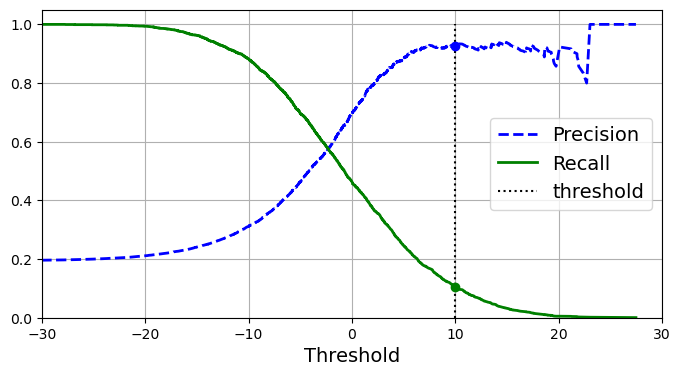

In [49]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-30, 30, 0, 1.05])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

Another way to select a good precisión/exhaustividad (*recall*) tradeoff is to plot precisión directly
against exhaustividad (*recall*).

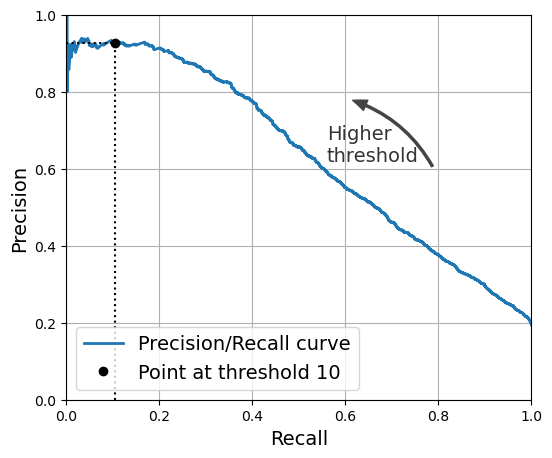

In [50]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 10")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

Vamos a suppose you decide to aim for 90% precisión. 

Looking up the first plot, we find that we need to use a umbral of about 6. 

To be more precise we can search for the lowest umbral that gives us at least 90% precisión.

In [51]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

5.51801863836684

In [52]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [53]:
precision_score(y_train_binary, y_train_pred_90)

0.9001692047377327

>A high-precisión classifier is not very useful if its exhaustividad (*recall*) is too low

In [54]:
recall_at_90_precision = recall_score(y_train_binary, y_train_pred_90)
recall_at_90_precision

0.22832618025751072

### The ROC Curve

The **receiver operating characteristic** (ROC) curve is another common tool used with
binary classifiers. 

The ROC curve plots the **true positive rate** (TPR), i.e., *exhaustividad (*recall*)*, against the **false positive rate** (FPR), which is one minus the **true negative rate**.

In [55]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_binary, y_scores)

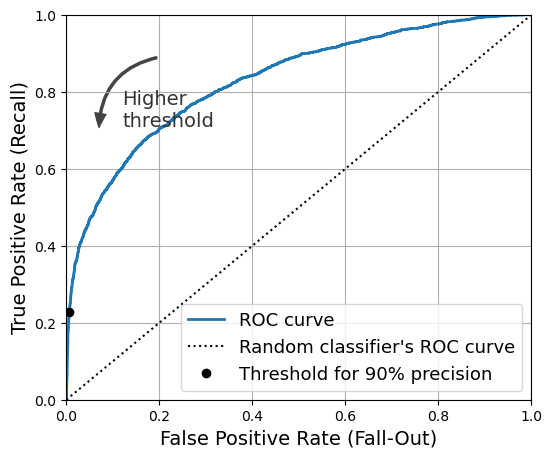

In [56]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
plt.show()

The dotted line represents the ROC curve of a purely random classifier.

>A good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the **area under the curve** (AUC). 

>A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [57]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_binary, y_scores)

0.83107930843745

This way we can compare different methods.



## Multiclass Clasificación

Some algorithms (such as **Random Forest** classifiers) are capable of handling multiple classes directly. 
Others (such as **Support Vector Machine** classifiers or **Linear** classifiers) are strictly binary classifiers. 

However, there are various strategies that we can use to perform multiclass classification using multiple
binary classifiers.

### One-versus-all (OvA) strategy

To classify the blood images into 8 classes (from 0 to 7), the  **one-versus-all** (OvA) strategy consists in entrenamientoing 8 binary classifiers, one for each class (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision puntuación from each classifier for that image and you select the class whose classifier outputs the highest puntuación.

### One-versus-one (OvO) strategy

Another strategy is to entrenamiento a binary classifier for every pair of digits: one to distinguish
0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.

If there are N classes, we need to entrenamiento $ N \times (N – 1) / 2$ classifiers. 

For the MedMNIST problem, this means entrenamientoing 28 binary classifiers! 

When we want to classify an image, we have to run the image 
through all 28 classifiers and see which class wins the most duels. The main advantage
of OvO is that each classifier only needs to be entrenamientoed on the part of the entrenamientoing
set for the two classes that it must distinguish.

Some algorithms (such as **Support Vector Machine** classifiers) scale poorly with the
size of the entrenamientoing set, so for these algorithms **OvO** is preferred since it is faster to
entrenamiento many classifiers on small entrenamientoing sets than entrenamientoing few classifiers on large
entrenamientoing sets. For most binary classification algorithms, however, **OvA** is preferred.

`Scikit-Learn` detects when you try to use a binary classification algorithm
for a multiclass classification task, and it automatically runs OvR or OvO,
depending on the algorithm.

>**Warning**: the following cell may take a few minutes to run:

In [58]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)


SGDClassifier(random_state=42)

In [59]:
sgd_clf.predict([some_img.flatten()])

array([5], dtype=uint8)

In [60]:
sgd_clf.decision_function([some_img.flatten()]).round()

array([[-18., -57.,  -9.,  -0., -25.,   7., -12., -82.]])

**Warning:** the following two cells may take a few minutes each to run:

In [61]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.68924003, 0.6635725 , 0.70396387])

Simply scaling the inputs increases exactitud

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.7002759 , 0.7002007 , 0.70973407])

## Error Analysis

Once we have found a promising modelo, we want to find ways to improve it. 

One way to do this is to analyze the types of errors it makes.

**Warning:** the following cell will take a few minutes to run:

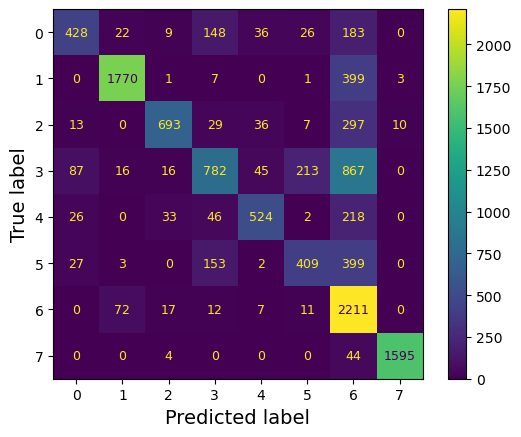

In [63]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

This matriz de confusión looks fairly good, since most images are on the main diagonal,
which means that they were classified correctly.

Vamos a divide each value in the matriz de confusión by the number of images in the corresponding class to compare error rates.

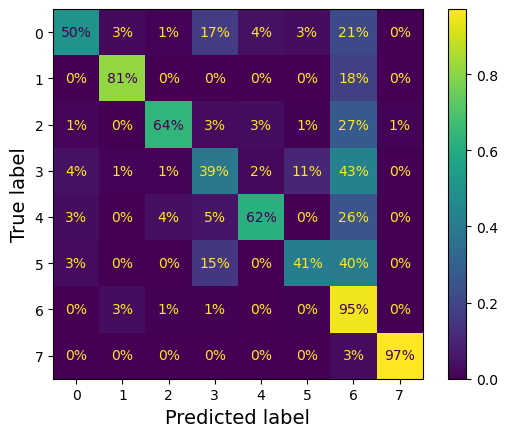

In [64]:
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

Now, to clearly see the kinds of errors the classifier makes, let's fill the diagonal with zeros.

In [65]:
sample_weight = (y_train_pred != y_train)

In [66]:
y_train_pred = y_train_pred.ravel()
y_train = y_train.ravel()


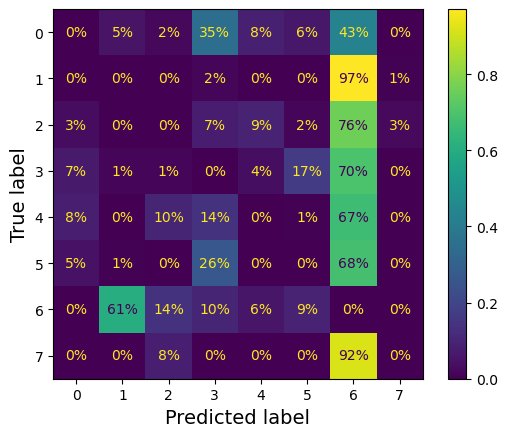

In [67]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

A few observations:

- The column for class 6 is quite bright, which tells that many images get misclassified as 6s. 

- However, the row for class 6 is not that bad, so that actual 6s in general get properly
classified as 6s.

- The matriz de confusión is not necessarily symmetrical. 

- 1s and 6s often get confused (in both directions).

Looking at this plot, it seems that our efforts should be spent on reducing the false 6s. 

- For example, we could try to gather more entrenamientoing data for cells that look like neutrophils (but are not) so the classifier can learn to distinguish them from real 6s.
- Alternatively, we could engineer new características that would help the classifier.
- Or we could preprocess the images (e.g., using Scikit-Image, Pillow, or
OpenCV) to make some patterns stand out more.

Analyzing individual errors can also be a good way to gain insights on what our
classifier is doing and why it is failing, but it is more difficult and time-consuming.

Vamos a plot examples of 1s and 6s. 

In [68]:
cl_a, cl_b = 1, 6
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

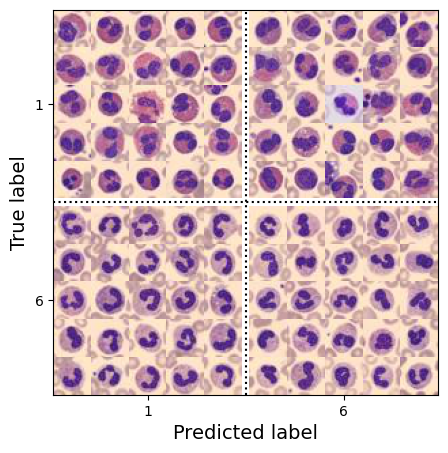

In [69]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28, 3), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

The reason is that we used a simple `SGDClassifier`, which is a linear modelo. 
All it does is assign a weight per class to each pixel, and when it sees a new image it just
sums up the weighted pixel intensities to get a puntuación for each class. So, this modelo easily confuses imags that differ only by a few pixels.

## Multilabel Clasificación

In some cases we may want our classifier to output multiple classes for each instance.

For example, if we have entrenamientoed a classifier to recognize three faces, for each picture we would like it to output multiple binary tags. This is called a **multilabel classification system**.

Vamos a look at a simpler example, a classifier that tell us if a digit is large ($\ge 7$) and/or odd. For this example, vamos a use the MNIST conjunto de datos.

In [70]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

X, y = mnist.data, mnist.target

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [71]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [72]:
knn_clf.predict([X[0]])

array([[False,  True]])

In [73]:
y[0]

'5'

This code computes the average F1 puntuación across all etiquetas:



In [74]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

## Multioutput Clasificación

The last type of classification task vamos a discuss here is called *multioutput-multiclass
classification* (or simply **multioutput classification**). 

It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have
more than two possible values).


To illustrate this, let’s build a system that removes noise from images. It will take as
input a noisy digit image, and it will (hopefully) output a clean digit image, represented
as an array of pixel intensities, just like the MNIST images.

>Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255).

Vamos a start by creating the entrenamientoing and prueba sets by taking the MNIST images and
adding noise to their pixel intensities using NumPy’s `randint()` function.


In [75]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

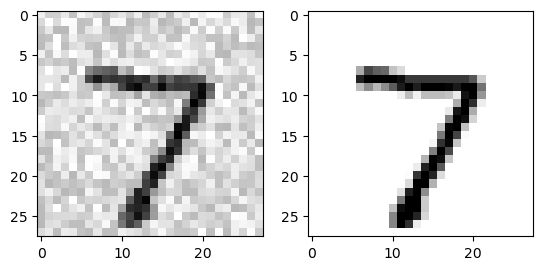

In [76]:
plt.subplot(121); plt.imshow(X_test_mod[0].reshape(28,28), cmap="binary")
plt.subplot(122); plt.imshow(y_test_mod[0].reshape(28,28), cmap="binary")
plt.show()

Now let’s entrenamiento the classifier and make it clean this image.

In [77]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])


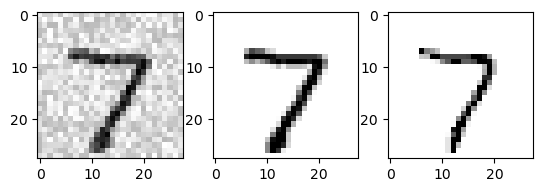

In [78]:
plt.subplot(131); plt.imshow(X_test_mod[0].reshape(28,28), cmap="binary")
plt.subplot(132); plt.imshow(y_test_mod[0].reshape(28,28), cmap="binary")
plt.subplot(133); plt.imshow(clean_digit.reshape(28,28), cmap="binary")
plt.show()